In [1]:
from collections import Counter
from Bio import SeqIO
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from keras.layers import Input, Dense, Lambda, Dropout
from keras.models import Model
from keras import backend as K
from keras import objectives
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


In [2]:
# Load data
data = pd.read_csv('dms.tsv', sep='\t')
data.head()

,sequence,mutation.count,slope,rsquared,fitness,mutations,positions,amino.acids
0,DVPLPAGWEMAKTRSGQRYFLNHVDQTTKWQDPR,3,-0.041970,0.001210,0.554755,"23R,33V,38K","23,33,38","R,V,K"
1,DVPLPAGWEMAKTSSDQRYVLNHIDQTTT*QDPR,3,1.327510,0.858360,1.433363,"25D,29V,39*","25,29,39","D,V,*"
2,EVPLTAGWEMAKTSSGQRYFLNHIDETTTWQDPR,3,-1.077273,0.733881,0.270673,"10E,14T,35E","10,14,35","E,T,E"
3,DVPLPAGWEKAKTSSGLRYFLNHIDQTTTWQVPR,3,0.561767,0.195068,0.843033,"19K,26L,41V","19,26,41","K,L,V"
4,YVALPAGWEMAKTSSGQRYFMNHIDQTTTWQDPR,3,1.786243,0.625087,1.969920,"10Y,12A,30M","10,12,30","Y,A,M"


In [3]:
# Get strings out
sequences = [s for s in data['sequence']]
len_counts = Counter([len(s) for s in sequences])


letters = set()
for s in sequences:
    letters = letters.union(s)
print(letters)

{'S', 'W', 'H', 'E', 'I', 'K', 'P', 'Q', 'T', 'Y', 'V', 'R', 'C', 'A', 'D', 'M', '*', 'N', 'L', 'G', 'F'}


In [4]:
# Convert sequences into numpy array.
char_array = np.chararray(shape=(len(sequences), max(len_counts.keys())), unicode=True)
# arr = np.array([list(rec) for rec in sequences])
char_array
for i, seq in enumerate(sequences):
    char_array[i, :] = list(seq)

In [5]:
char_array.shape

(47000, 34)

In [6]:
lb = LabelBinarizer()
lb.fit(list(letters))

input_array = np.zeros(shape=(char_array.shape[0], max(len_counts.keys()) * len(letters)))
print(input_array.shape)
for i in range(char_array.shape[1]):
    input_array[:, i*len(letters):(i+1)*len(letters)] = lb.transform(char_array[:, i])

(47000, 714)


In [7]:
# Sanity check
np.unique(input_array)

array([ 0.,  1.])

In [8]:
# Sanity check: should really be one-of-K
input_array[0, 0:len(letters)]

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [9]:
intermediate_dim = 1000
encoding_dim = 2
latent_dim = encoding_dim
epsilon_std = 1.0
nb_epoch = 250

x = Input(shape=(input_array.shape[1],))
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(latent_dim, ), mean=0.,
                              std=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon


def vae_loss(x, x_decoded_mean):
    xent_loss = input_array.shape[1] * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
x_decoded_mean = Dense(input_array.shape[1], activation='sigmoid')(z_mean)

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='adam', loss=vae_loss)

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)
encoder_var = Model(x, z_log_var)

x_train, x_test = train_test_split(input_array)

early_stopping = EarlyStopping(monitor="val_loss", patience=3)

In [10]:
# build the decoder
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = vae.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

In [11]:
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        validation_data=(x_test, x_test),
        callbacks=[early_stopping],
       )

Train on 35250 samples, validate on 11750 samples
Epoch 1/250
35250/35250 [==============================] - 3s - loss: 102.1395 - val_loss: 50.7270

In [12]:
embeddings_mean = encoder.predict(input_array)
embeddings_var = encoder_var.predict(input_array)

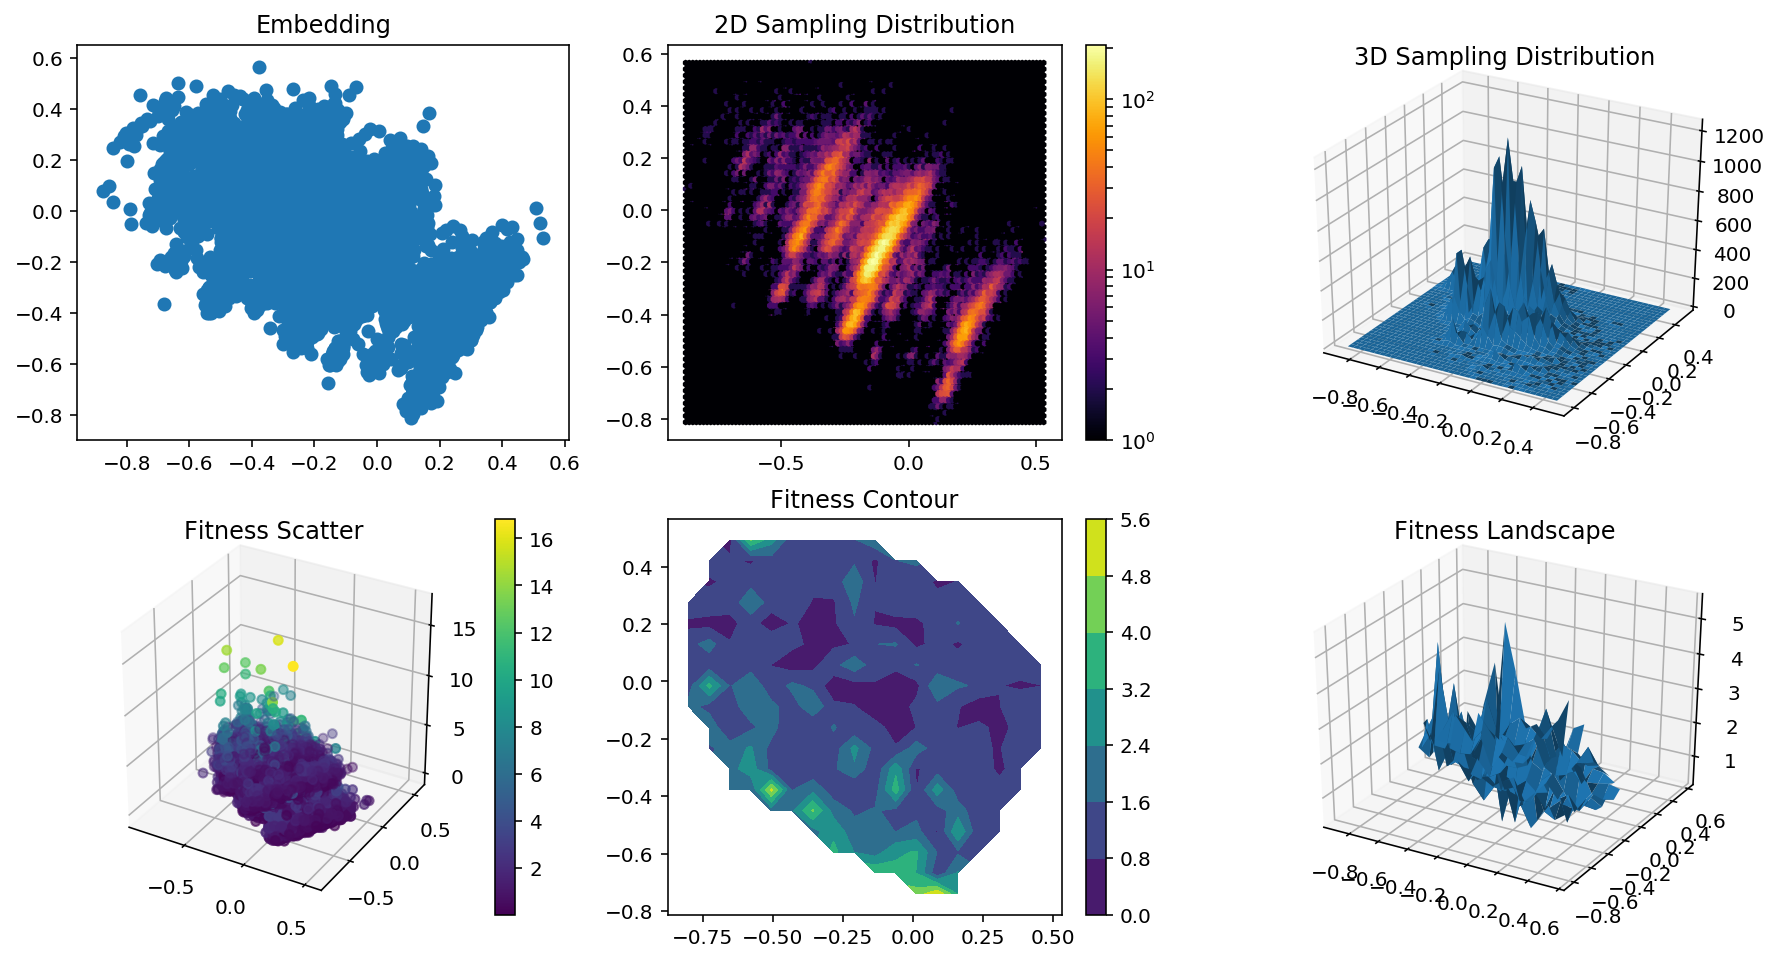

In [13]:
from matplotlib.mlab import griddata

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(2, 3, 1)
plt.scatter(embeddings_mean[:, 0], embeddings_mean[:, 1])
# plt.colorbar(ax=ax1)
ax1.set_title('Embedding')

ax2 = fig.add_subplot(2, 3, 2)
hb = ax2.hexbin(embeddings_mean[:, 0], embeddings_mean[:, 1], norm=colors.LogNorm(), cmap='inferno')
fig.colorbar(hb, ax=ax2)
ax2.set_title('2D Sampling Distribution')

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
xs = embeddings_mean[:, 0]
ys = embeddings_mean[:, 1]
fitness = data['fitness']
histo, xbins, ybins = np.histogram2d(xs, ys, bins=40)
xx, yy = np.meshgrid(xbins, ybins)
xx = xx[0:-1, :-1]
yy = yy[0:-1, :-1]
# ax3.view_init(elev=30, azim=0)
ax3.plot_surface(xx, yy, histo)
ax3.set_title('3D Sampling Distribution')

def grid(x, y, z, resX=50, resY=50):
    "Convert 3 column data to matplotlib grid"
    xi = np.linspace(min(x), max(x), resX)
    yi = np.linspace(min(y), max(y), resY)
    Z = griddata(x, y, z, xi, yi, interp='linear')
    X, Y = np.meshgrid(xi, yi)
    return X, Y, Z

X, Y, Z = grid(xs, ys, fitness, resX=20, resY=20)

emb_dict = dict()
for i in range(encoding_dim):
    emb_dict[i] = embeddings_mean[:, i]

ax4 = fig.add_subplot(2, 3, 4, projection='3d', alpha=0.)
fitscatter = ax4.scatter(xs, ys, fitness, c=fitness, cmap='viridis')
# fitscatter = ax4.scatter(emb_dict[0], emb_dict[1], emb_dict[2], c=fitness, cmap='viridis')
# ax4.view_init(elev=30, azim=0)
fig.colorbar(fitscatter, ax=ax4)
ax4.set_title('Fitness Scatter')

ax5 = fig.add_subplot(2, 3, 5)
cf = ax5.contourf(X, Y, Z)
ax5.set_title('Fitness Contour')
fig.colorbar(cf, ax=ax5)

ax6 = fig.add_subplot(2, 3, 6, projection='3d')
ax6.plot_surface(X, Y, Z)
ax6.set_title('Fitness Landscape')

What's the interpretation here? I think it's something like this.

The embedded n-dimensional space is rugged, but nonetheless has a few regions where high fitness is possible.

What should we try next?

- Train a 1D GP on the marginal distribution of fitness scores on each embedding.
- Train a 2D GP on the whole embedding space?

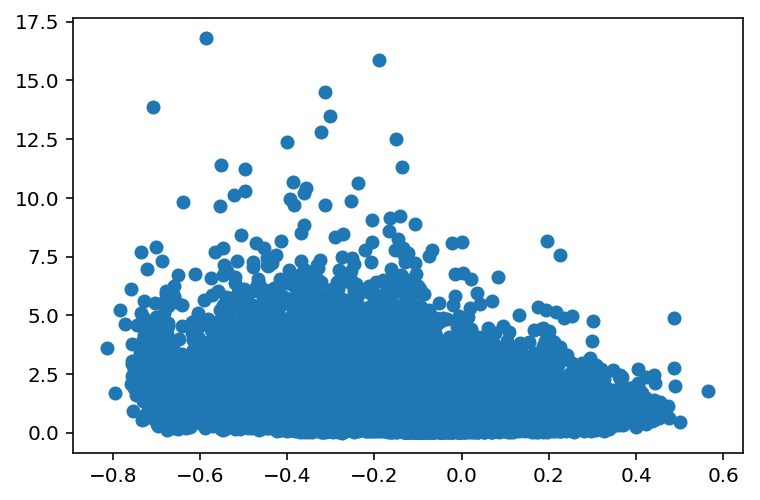

In [14]:
plt.scatter(embeddings_mean[:, 1], fitness)

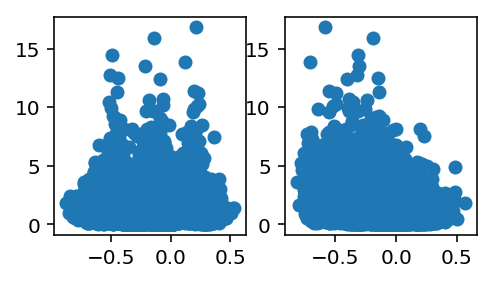

In [15]:
fig = plt.figure(figsize=(10, 2))
for dim in range(encoding_dim):
    ax = fig.add_subplot(1, 5, dim+1)
    ax.scatter(embeddings_mean[:, dim], data['fitness'])

# plt.scatter(X, Z)
# plt.scatter(Y, Z)

This is a good sanity-check. The marginal distributions learned look ball-ish, though it looks like it's going to be touch to interpretably learn the "features" from the middle distribution that predict "fitness".

In [16]:
embeddings_mean.shape

(47000, 2)

In [21]:
# Are there 47,000 unique values?
np.unique(embeddings_mean).shape[0] / 2

46944.0